### Cat and Dog Sound Analysis RNN

https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs?resource=download-directory


In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten


In [17]:
train_dir = "cats_dogs/train"
test_dir = "cats_dogs/test"

In [ ]:
"""
# Define paths
# This was used as the fileset we got was messed up, this copied to audios not in the folder to the correct folders atomatically
# This is no longer needed after the first rin

def move_files_to_classes(directory):

    #Move unsorted files into their respective class subdirectories
    #based on the filenames (e.g., 'cat_*.wav' or 'dog_*.wav').

    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):  # Ensure it's a file, not a folder
            if file.startswith("cat"):
                os.rename(file_path, os.path.join(directory, "cat", file))
            elif file.startswith("dog"):
                os.rename(file_path, os.path.join(directory, "dog", file))

# Move files in train and test directories
move_files_to_classes(train_dir)
move_files_to_classes(test_dir)

# Verify train directory
print("Files in train_dir after sorting:", os.listdir(train_dir))
# Verify test directory
print("Files in test_dir after sorting:", os.listdir(test_dir))

# Check subdirectories in train and test
print("Subdirectories in train_dir:", os.listdir(train_dir))
print("Subdirectories in test_dir:", os.listdir(test_dir))

# Check the contents of the `cat` and `dog` folders
print("\nFiles in train_dir/cat:", os.listdir(os.path.join(train_dir, "cat")))
print("Files in train_dir/dog:", os.listdir(os.path.join(train_dir, "dog")))
print("\nFiles in test_dir/cat:", os.listdir(os.path.join(test_dir, "cat")))
print("Files in test_dir/dog:", os.listdir(os.path.join(test_dir, "dog")))

"""


Files in train_dir after sorting: ['cat', 'dog']
Files in test_dir after sorting: ['cat', 'dog']
Subdirectories in train_dir: ['cat', 'dog']
Subdirectories in test_dir: ['cat', 'dog']

Files in train_dir/cat: ['cat_74.wav', 'cat_60.wav', 'cat_48.wav', 'cat_132.wav', 'cat_127.wav', 'cat_49.wav', 'cat_9.wav', 'cat_63.wav', 'cat_77.wav', 'cat_131.wav', 'cat_125.wav', 'cat_119.wav', 'cat_118.wav', 'cat_124.wav', 'cat_89.wav', 'cat_62.wav', 'cat_8.wav', 'cat_72.wav', 'cat_99.wav', 'cat_108.wav', 'cat_134.wav', 'cat_120.wav', 'cat_121.wav', 'cat_109.wav', 'cat_98.wav', 'cat_73.wav', 'cat_71.wav', 'cat_65.wav', 'cat_123.wav', 'cat_136.wav', 'cat_122.wav', 'cat_64.wav', 'cat_70.wav', 'cat_151.wav', 'cat_150.wav', 'cat_16.wav', 'cat_146.wav', 'cat_147.wav', 'cat_153.wav', 'cat_15.wav', 'cat_39.wav', 'cat_11.wav', 'cat_157.wav', 'cat_142.wav', 'cat_156.wav', 'cat_10.wav', 'cat_38.wav', 'cat_12.wav', 'cat_140.wav', 'cat_154.wav', 'cat_155.wav', 'cat_141.wav', 'cat_13.wav', 'cat_22.wav', 'cat_164.

### Load Data

When working with the audio dataset, I noticed several challenges that required careful preprocessing to ensure the data was suitable for training a deep learning model. First, the audio files varied in length, which is a common issue in audio datasets. Neural networks, especially RNNs, require inputs of fixed length, so I addressed this by padding shorter signals with zeros and truncating longer signals to a standardized length of 16,000 samples (representing 1 second of audio). This ensures that the model receives consistent input, preventing errors during training. 

I also needed to confirm that the dataset was properly organized and balanced. To check for potential class imbalances, I calculated the distribution of `cat` and `dog` labels in both the training and testing datasets. This step is critical because imbalances can bias the model towards predicting the majority class, reducing its ability to generalize. By printing the class distribution, I could identify whether further balancing was necessary. 

Another problem I anticipated was noise or corruption in the audio signals, which could negatively impact the model's performance. To verify the quality of the loaded audio files, I plotted the waveform of the first training and testing samples. This visualization allowed me to inspect the signals and confirm that they were processed correctly, with no significant noise, clipping, or unexpected artifacts. 

Finally, I calculated statistics like the minimum, maximum, and mean signal lengths to ensure that the padding and truncation worked as expected, guaranteeing uniformity across all samples. Each of these steps was designed to address potential data issues upfront, ensuring that the dataset was clean, balanced, and ready for training. This proactive approach minimizes the risk of encountering data-related errors later in the pipeline and sets the stage for building an effective and robust model.

Number of training samples: 210
Number of testing samples: 67

Training class distribution:
  cat: 125 samples
  dog: 85 samples

Testing class distribution:
  cat: 39 samples
  dog: 28 samples

Audio signal details:
  Training data signal length: Min = 16000, Max = 16000, Mean = 16000.0
  Testing data signal length: Min = 16000, Max = 16000, Mean = 16000.0

First 5 training labels: ['cat', 'cat', 'cat', 'cat', 'cat']
First 5 testing labels: ['cat', 'cat', 'cat', 'cat', 'cat']


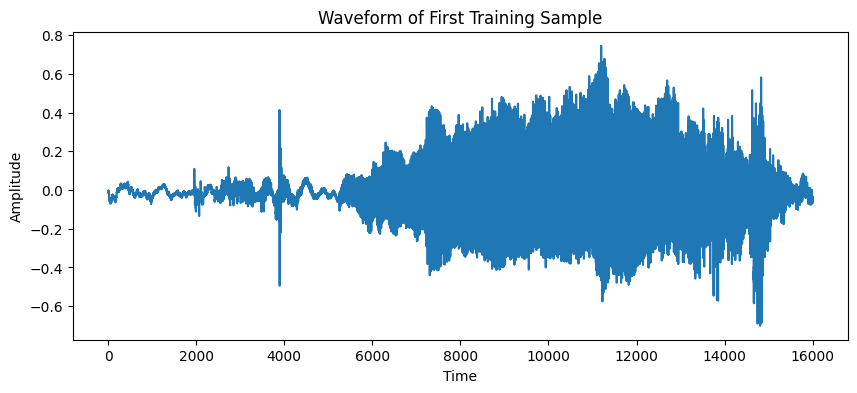

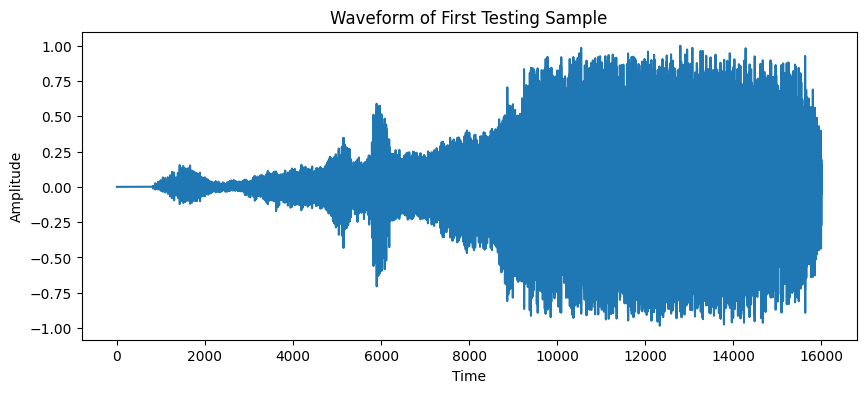

In [ ]:


def load_audio_files(directory, target_length=16000):
    """
    Load audio files from the given directory, extract their waveforms,
    and pad/truncate to a fixed length.
    """
    data = []
    labels = []
    for label in os.listdir(directory):  # 'cats' and 'dogs'
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                if file_path.endswith(".wav"):
                    # Load audio signal
                    signal, sr = librosa.load(file_path, sr=16000)  # Standardize sample rate
                    
                    # Pad or truncate signal
                    if len(signal) < target_length:
                        signal = np.pad(signal, (0, target_length - len(signal)))
                    elif len(signal) > target_length:
                        signal = signal[:target_length]
                    
                    data.append(signal)
                    labels.append(label)
    return np.array(data), labels


# Load training and test data
train_data, train_labels = load_audio_files(train_dir)
test_data, test_labels = load_audio_files(test_dir)

# Print details about the data
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# Check class distribution
from collections import Counter
train_class_distribution = Counter(train_labels)
test_class_distribution = Counter(test_labels)
print("\nTraining class distribution:")
for label, count in train_class_distribution.items():
    print(f"  {label}: {count} samples")

print("\nTesting class distribution:")
for label, count in test_class_distribution.items():
    print(f"  {label}: {count} samples")

# Check lengths of audio signals
train_lengths = [len(signal) for signal in train_data]
test_lengths = [len(signal) for signal in test_data]

print("\nAudio signal details:")
print(f"  Training data signal length: Min = {min(train_lengths)}, Max = {max(train_lengths)}, Mean = {np.mean(train_lengths)}")
print(f"  Testing data signal length: Min = {min(test_lengths)}, Max = {max(test_lengths)}, Mean = {np.mean(test_lengths)}")


# Visualize the waveform of the first training sample
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data[0])
plt.title("Waveform of First Training Sample")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Visualize the waveform of the first testing sample
plt.figure(figsize=(10, 4))
plt.plot(test_data[0])
plt.title("Waveform of First Testing Sample")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


In [22]:
import numpy as np

def shuffle_data(data, labels):
    """
    Shuffle data and labels together.
    """
    # Convert data and labels to NumPy arrays if they are not already
    data = np.array(data)
    labels = np.array(labels)

    # Create indices and shuffle
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    return data[indices], labels[indices]

# Shuffle training data
train_data, train_labels = shuffle_data(train_data, train_labels)

# Shuffle testing data
test_data, test_labels = shuffle_data(test_data, test_labels)

# Verify first 5 labels
print("\nFirst 5 training labels after shuffling:", train_labels[:5])
print("First 5 testing labels after shuffling:", test_labels[:5])



First 5 training labels after shuffling: ['dog' 'dog' 'cat' 'dog' 'cat']
First 5 testing labels after shuffling: ['cat' 'dog' 'cat' 'cat' 'cat']


In [20]:
from sklearn.utils import resample

def balance_classes(data, labels):
    # Separate classes
    cat_data = [data[i] for i in range(len(labels)) if labels[i] == 'cat']
    dog_data = [data[i] for i in range(len(labels)) if labels[i] == 'dog']
    
    # Undersample the majority class
    cat_data = resample(cat_data, replace=False, n_samples=len(dog_data), random_state=42)
    
    # Combine and shuffle
    balanced_data = np.array(cat_data + dog_data)
    balanced_labels = np.array(['cat'] * len(cat_data) + ['dog'] * len(dog_data))
    
    shuffle_indices = np.random.permutation(len(balanced_labels))
    return balanced_data[shuffle_indices], balanced_labels[shuffle_indices]

# Balance the training data
train_data, train_labels = balance_classes(train_data, train_labels)

# Check the new distribution
print(f"Balanced Training class distribution: {Counter(train_labels)}")


Balanced Training class distribution: Counter({'dog': 85, 'cat': 85})


### Normalize Audio

Normalizing audio signals to have zero mean and unit variance ensures consistent amplitude across the 210 training and 67 testing samples. This step is particularly important for smaller datasets, as it prevents the model from overfitting to outliers with higher amplitudes and improves generalization during training.

In [4]:
def normalize_audio(data):
    """
    Normalize audio signals to zero mean and unit variance.
    """
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

# Normalize train and test data
train_data = normalize_audio(train_data)
test_data = normalize_audio(test_data)


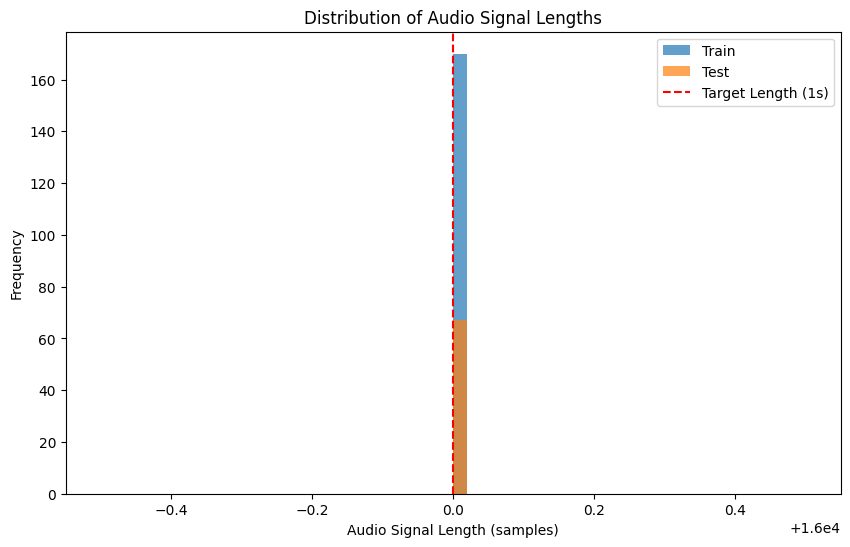

In [5]:
# Calculate lengths of raw audio signals
train_lengths = [len(signal) for signal in train_data]
test_lengths = [len(signal) for signal in test_data]

# Plot histogram of audio lengths
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test')
plt.axvline(16000, color='r', linestyle='--', label='Target Length (1s)')
plt.xlabel("Audio Signal Length (samples)")
plt.ylabel("Frequency")
plt.title("Distribution of Audio Signal Lengths")
plt.legend()
plt.show()


### Mel Spectrograms

The normalization of Mel spectrograms ensures the 128 frequency bins and 32 time steps are scaled consistently across all 210 training samples and 67 testing samples. This prevents the model from focusing on differences in magnitude and encourages it to learn meaningful patterns in the audio features.

In [6]:
def preprocess_audio_data(data, labels, sr=16000, n_mels=128):
    """
    Convert audio waveforms to normalized Mel spectrograms and encode labels.
    """
    features = []
    for signal in data:
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
        mel_spec_db = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)  # Normalize
        features.append(mel_spec_db)

    # Convert to numpy arrays
    features = np.array(features)
    features = features.reshape(features.shape[0], features.shape[1], features.shape[2], 1)  # Add channel dimension

    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    return features, encoded_labels, encoder


# Preprocess training and test data
X_train, y_train, encoder = preprocess_audio_data(train_data, train_labels)
X_test, y_test, _ = preprocess_audio_data(test_data, test_labels)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (170, 128, 32, 1)
Testing data shape: (67, 128, 32, 1)


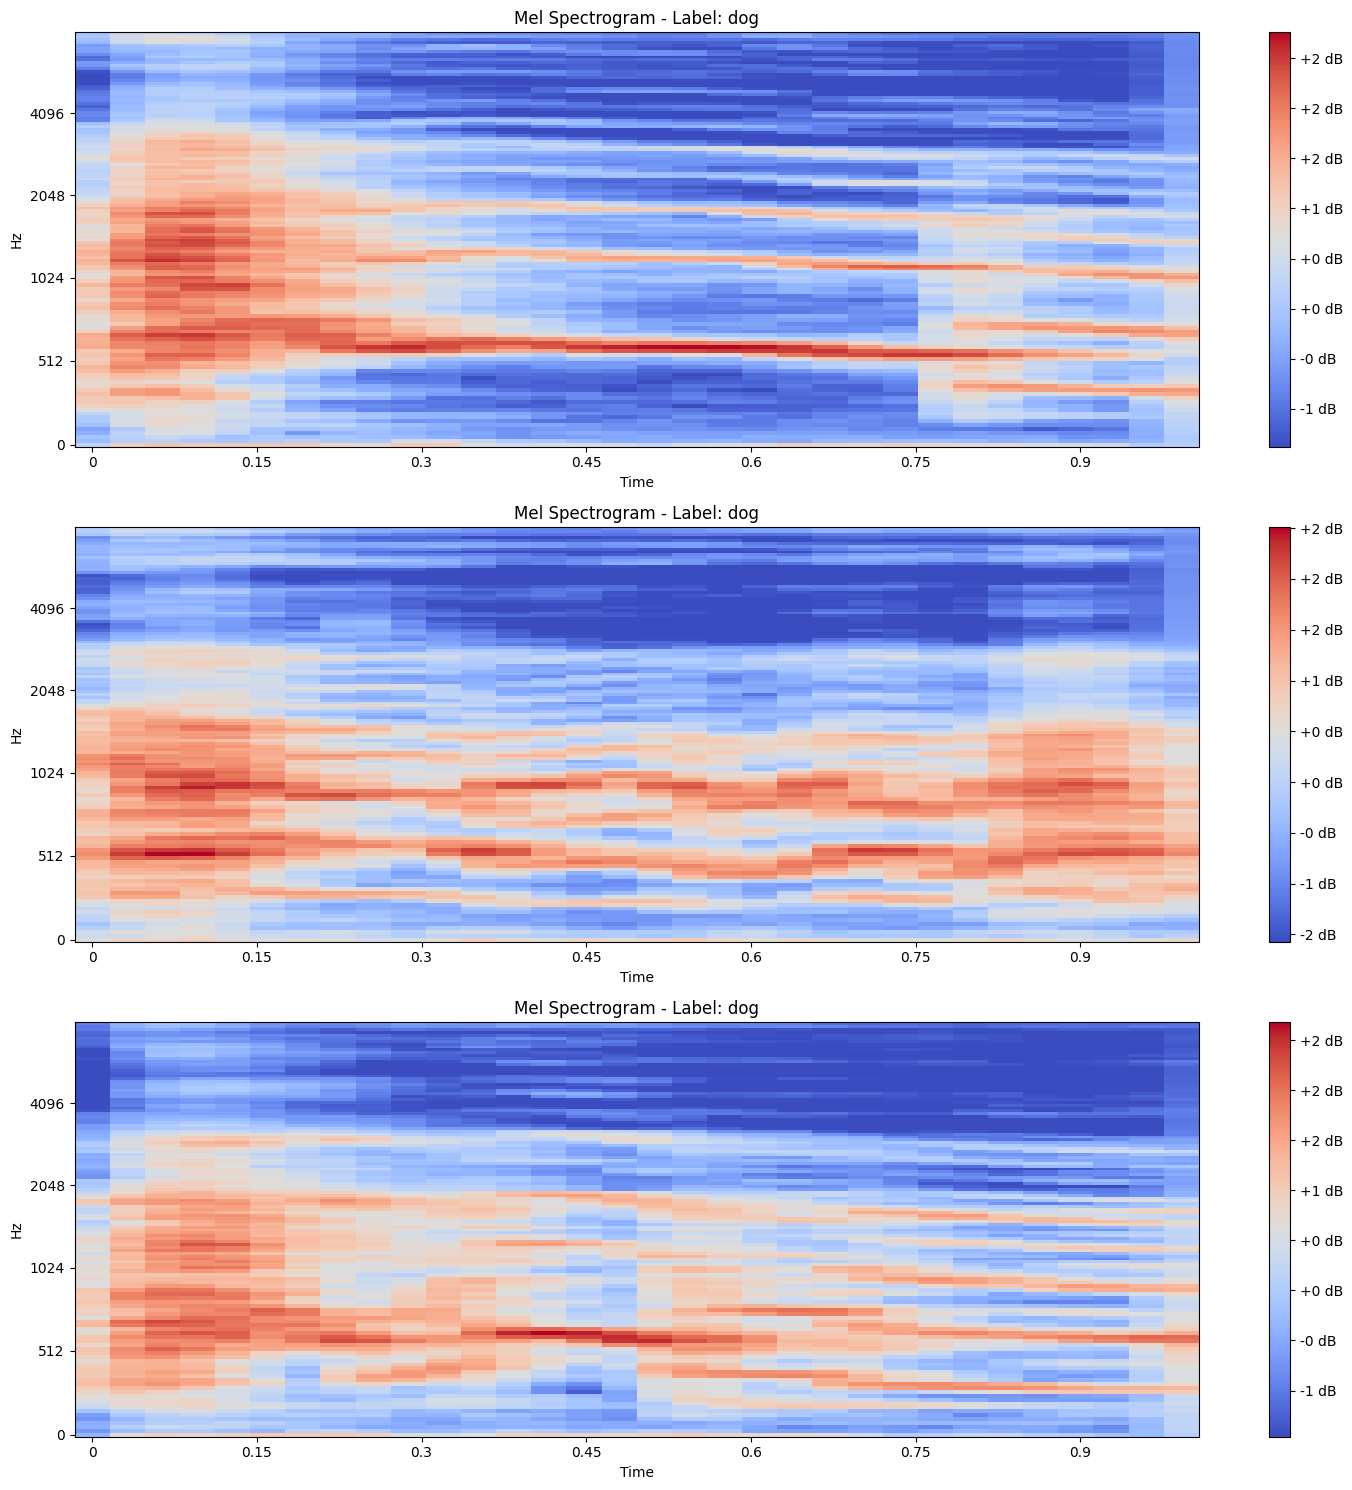

In [7]:
# Visualize Mel spectrograms for a few samples
def plot_mel_spectrograms(data, labels, encoder, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        mel_spec = data[i].squeeze()  # Remove channel dimension
        label = encoder.inverse_transform([labels[i]])[0]
        plt.subplot(num_samples, 1, i + 1)
        librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram - Label: {label}")
        plt.tight_layout()
    plt.show()

# Plot spectrograms for the first few samples in the training data
plot_mel_spectrograms(X_train, y_train, encoder)
